In [1]:
import duckdb
import pyarrow.dataset as ds
import pandas as pd

In [2]:
dataset = ds.dataset("data/status", format="parquet", partitioning="hive")

In [3]:
dataset.count_rows()

382286723

In [4]:
con = duckdb.connect()
con = con.register("status", dataset)

In [5]:
schema_df = con.execute(
    """
    describe status"""
).df()

In [6]:
schema_df

,column_name,column_type,null,key,default,extra
0,is_charging_station,BOOLEAN,YES,NaN,NaN,NaN
1,is_installed,BIGINT,YES,NaN,NaN,NaN
2,is_renting,BIGINT,YES,NaN,NaN,NaN
3,is_returning,BIGINT,YES,NaN,NaN,NaN
4,last_reported,BIGINT,YES,NaN,NaN,NaN
5,num_bikes_available,BIGINT,YES,NaN,NaN,NaN
6,num_bikes_available_types,"STRUCT(ebike BIGINT, mechanical BIGINT)",YES,NaN,NaN,NaN
7,num_bikes_disabled,BIGINT,YES,NaN,NaN,NaN
8,num_docks_available,BIGINT,YES,NaN,NaN,NaN
9,num_docks_disabled,BIGINT,YES,NaN,NaN,NaN


In [19]:
duckdf = con.execute(
    """
    select
        make_timestamp(year, month, day, hour, minute, 0.0) as ts,
        station_id,
        hour,
        minute,
        dayofweek(make_timestamp(year, month, day, hour, minute, 0.0)) as dow,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        minute(lead(make_timestamp(year, month, day, hour, minute, 0.0), 5) over (
            partition by station_id
            order by make_timestamp(year, month, day, hour, minute, 0.0) asc
        ) - make_timestamp(year, month, day, hour, minute, 0.0))  as minutes_bt_check,
        lead(num_bikes_available, 5) over (
            partition by station_id
            order by make_timestamp(year, month, day, hour, minute, 0.0) asc
        ) as bikes_available,
    from
        status
    where
        month > 1 and
        station_id = 3 and
        status = 'IN_SERVICE' and
        year = 2022"""
).df()
duckdf.head()

,ts,station_id,hour,minute,dow,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,minutes_bt_check,bikes_available
0,2022-02-01 00:00:00,3,0,0,2,0,1,19,0,5.0,0.0
1,2022-02-01 00:01:00,3,0,1,2,0,1,19,0,5.0,0.0
2,2022-02-01 00:02:00,3,0,2,2,0,1,19,0,5.0,0.0
3,2022-02-01 00:03:00,3,0,3,2,0,1,19,0,5.0,0.0
4,2022-02-01 00:04:00,3,0,4,2,0,1,19,0,5.0,0.0


In [20]:
len(duckdf)

377083

In [21]:

from prophet import Prophet

In [22]:
duckdf['ds'] = duckdf['ts']
duckdf['y'] = duckdf['num_bikes_available']

duckdf['floor'] = 0
duckdf['cap'] = duckdf['num_docks_available'] + duckdf['num_bikes_available']
# m = Prophet(growth='logistic')
# m.fit(duckdf[duckdf["ds"]< '2022-03-01' ][["ds", "y", "floor", "cap"]])
m = Prophet()
m.fit(duckdf[(duckdf["ds"] >= '2022-05-01') & (duckdf["ds"] < '2022-08-01')][["ds", "y"]])

20:38:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing


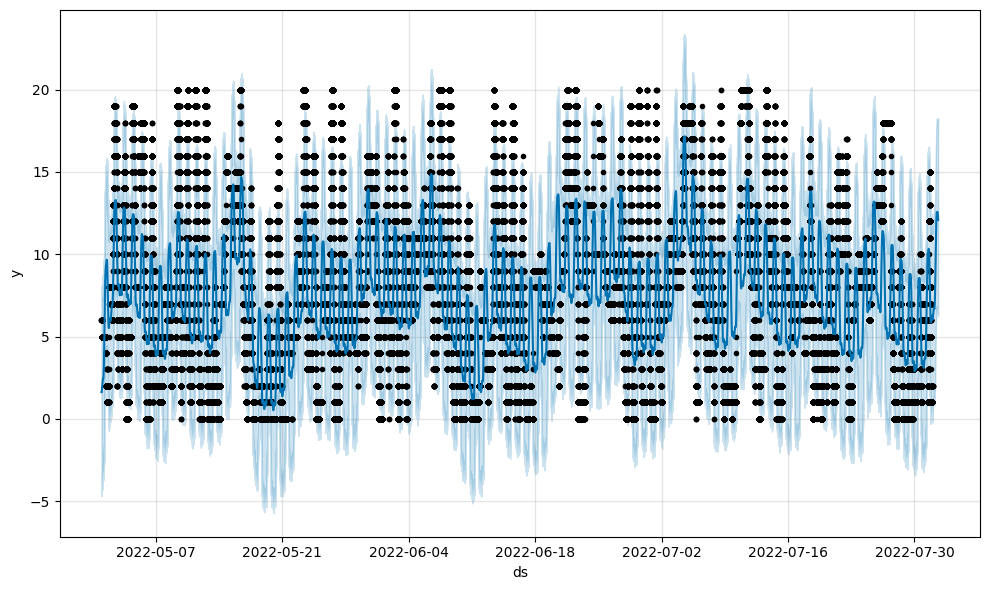

In [23]:
future = m.make_future_dataframe(periods=15, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

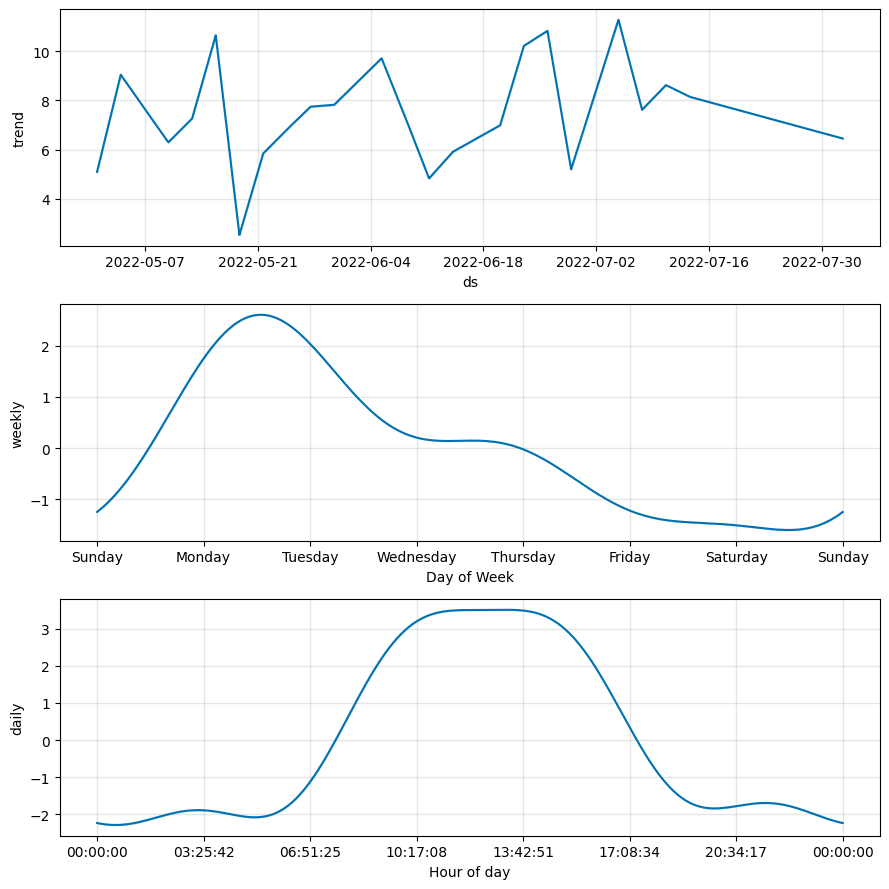

In [24]:
fig = m.plot_components(fcst);

In [25]:
fcst = m.predict(duckdf[(duckdf["ds"] >= '2022-08-01') & (duckdf["ds"] < '2022-09-01')][["ds", "y"]])

In [26]:
fcst["y"] = duckdf[(duckdf["ds"] >= '2022-08-01') & (duckdf["ds"] < '2022-09-01')]["y"].values

In [27]:
fcst["bike_a_pred"] = fcst["yhat"]>0
fcst["bike_a"] = fcst["y"]>0
fcst[["bike_a", "bike_a_pred"]]
len(fcst[fcst["bike_a"] == fcst["bike_a_pred"]]) / len(fcst)

0.854831118183652

In [28]:
len(fcst[(fcst["bike_a"] == fcst["bike_a_pred"]) & (fcst["bike_a"] == False)]) / len(fcst[fcst["bike_a"] == False])

0.0

In [36]:
train_set = duckdf[(duckdf["ds"] >= '2022-05-01') & (duckdf["ds"] < '2022-08-01')][["num_bikes_available", "hour", "dow"]]

In [37]:
train_set["avail_1_min"] = train_set["num_bikes_available"].shift(1)
train_set = train_set.dropna()

In [39]:
train_set.head()

,num_bikes_available,hour,dow,avail_1_min
112985,6,0,0,6.0
112986,6,0,0,6.0
112987,6,0,0,6.0
112988,6,0,0,6.0
112989,6,0,0,6.0


In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

In [44]:
rf_pipe = make_pipeline(ColumnTransformer([("ohe",  OneHotEncoder(), ["hour", "dow"])], remainder="passthrough"), RandomForestRegressor())


In [45]:
rf_pipe.fit(train_set[["num_bikes_available", "hour", "dow"]], train_set["avail_1_min"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['hour', 'dow'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [48]:
test_set = duckdf[(duckdf["ds"] >= '2022-08-01') & (duckdf["ds"] < '2022-09-01')][["num_bikes_available", "hour", "dow", "bikes_available"]]


In [55]:
test_set["num_bikes_available_0"] = test_set["num_bikes_available"]
for i in range(1,6):
    test_set["p"+str(i)] = rf_pipe.predict(test_set[["num_bikes_available", "hour", "dow"]])
    test_set["num_bikes_available"] = test_set["p"+str(i)]

In [59]:
test_set["bike_a_pred"] = test_set["bikes_available"]>0
test_set["bike_a"] = test_set["p5"]>0
test_set[["bike_a", "bike_a_pred"]]
len(test_set[test_set["bike_a"] == test_set["bike_a_pred"]]) / len(test_set)

0.9040948517381268

In [61]:
len(test_set[(test_set["bike_a"] == test_set["bike_a_pred"]) & (test_set["bike_a"] == False)]) / len(test_set[test_set["bike_a"] == False])

0.9769965277777778

In [63]:
test_set.tail()

,num_bikes_available,hour,dow,bikes_available,p1,p0,num_bikes_available_0,p2,p3,p4,p5,bike_a_pred,bike_a
289871,3.02321,23,3,3.0,3.02321,3,3,3.02321,3.02321,3.02321,3.02321,True,True
289872,3.02321,23,3,3.0,3.02321,3,3,3.02321,3.02321,3.02321,3.02321,True,True
289873,3.02321,23,3,3.0,3.02321,3,3,3.02321,3.02321,3.02321,3.02321,True,True
289874,3.02321,23,3,3.0,3.02321,3,3,3.02321,3.02321,3.02321,3.02321,True,True
289875,3.02321,23,3,3.0,3.02321,3,3,3.02321,3.02321,3.02321,3.02321,True,True


In [65]:
test_set["bike_a_pred"] = test_set["bikes_available"]>0
test_set["bike_a"] = test_set["num_bikes_available"]>0
test_set[["bike_a", "bike_a_pred"]]
(len(test_set[test_set["bike_a"] == test_set["bike_a_pred"]]) / len(test_set),
len(test_set[(test_set["bike_a"] == test_set["bike_a_pred"]) & (test_set["bike_a"] == False)]) / len(test_set[test_set["bike_a"] == False]))

(0.9040948517381268, 0.9769965277777778)

In [77]:
rf_pipe.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('ohe', OneHotEncoder(), ['hour', 'dow'])])),
 ('randomforestregressor', RandomForestRegressor())]

In [79]:
list(zip(rf_pipe["columntransformer"].get_feature_names_out(), rf_pipe["randomforestregressor"].feature_importances_))

[('ohe__hour_0', 1.3187655750559952e-06),
 ('ohe__hour_1', 9.155388602297792e-07),
 ('ohe__hour_2', 1.2804057906253137e-06),
 ('ohe__hour_3', 5.672614386928167e-07),
 ('ohe__hour_4', 1.64648098593538e-07),
 ('ohe__hour_5', 5.751536389908628e-07),
 ('ohe__hour_6', 3.4225507526625065e-06),
 ('ohe__hour_7', 4.698454037004743e-06),
 ('ohe__hour_8', 5.490938013898081e-06),
 ('ohe__hour_9', 9.516735034753663e-06),
 ('ohe__hour_10', 5.302648176506633e-06),
 ('ohe__hour_11', 3.95079407271158e-06),
 ('ohe__hour_12', 3.3663928569487764e-06),
 ('ohe__hour_13', 4.466926081301882e-06),
 ('ohe__hour_14', 3.6902737208961634e-06),
 ('ohe__hour_15', 4.302743468674135e-06),
 ('ohe__hour_16', 7.078601189739816e-06),
 ('ohe__hour_17', 5.419809159438569e-06),
 ('ohe__hour_18', 4.189282996689166e-06),
 ('ohe__hour_19', 2.267213937574907e-06),
 ('ohe__hour_20', 1.4361780232630028e-06),
 ('ohe__hour_21', 1.0848673498087829e-06),
 ('ohe__hour_22', 2.2299911247518656e-06),
 ('ohe__hour_23', 1.1409716036136033e-